In [1]:
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
import matplotlib as matplotlib

#%matplotlib inline
#from matplotlib.patches import Ellipse

%matplotlib notebook

import math

import matplotlib.patches as mpatches

## splash particle simulation


only for showing particle trajectories and the flow field. Figure: trajs.png, flow10.png

In [2]:
# first create an impact point -- uniform distrn in projected unit circle-- impact parameter
# returns a vector [x,y,z] on sphere z>0 hemisphere
def create_pj():
    phi = np.random.uniform(low=0,high=2*np.pi)
    z  = np.random.uniform(low=0,high=1)
    x = np.sqrt(z)*np.cos(phi)  # sqrt makes distribution even on circle
    y = np.sqrt(z)*np.sin(phi)
    z = np.sqrt(1 - x**2 - y**2)
    r = np.array([x,y,z]) # returns a vector 
    return r  # impact point on sphere, units R_a radius of planetesimal


In [21]:
# create a rotation matrix, rotates about axis, an angle theta in radians
def rotation_matrix(axis, theta):
    """
    Return the rotation matrix associated with counterclockwise rotation about
    the given axis by theta in radians.
    https://en.wikipedia.org/wiki/Euler%E2%80%93Rodrigues_formula
    """
    axis = np.asarray(axis)
    axis = axis / math.sqrt(np.dot(axis, axis))  # normalize axis
    a = np.cos(theta/2.0)
    b, c, d = -axis * np.sin(theta/2.0)
    aa, bb, cc, dd = a * a, b * b, c * c, d * d
    bc, ad, ac, ab, bd, cd = b * c, a * d, a * c, a * b, b * d, c * d
    return np.array([[aa + bb - cc - dd, 2 * (bc + ad), 2 * (bd - ac)],
                     [2 * (bc - ad), aa + cc - bb - dd, 2 * (cd + ab)],
                     [2 * (bd + ac), 2 * (cd - ab), aa + dd - bb - cc]])


# compute a velocity direction for a splash particle 
# this creates a 45 degree from normal direction from x,y,z on sphere and downrange 
# inputs: 
#    r should be an array [x,y,z] and unit vector 
#    u is impact velocity direction (-zhat if coming from north pole)
# returns: unit vector in 45 degree direction from local normal and in plane 
#  spanned by impact velocity and local normal  
#  should be away from velocity direction -- in the downrange direction!
def create_splash_dir(r,u):
    rhat = np.copy(r)/np.sqrt(np.dot(r,r))
    uhat = np.copy(u)/np.sqrt(np.dot(u,u))
    dvec = uhat - np.dot(uhat,rhat)*rhat 
    dvec_mag = np.sqrt(np.dot(dvec,dvec))
    dvec_hat = dvec/dvec_mag  # this is down range vector!!!! 
    vhat2 = dvec_hat *np.cos(45*np.pi/180) + rhat*np.sin(45*np.pi/180)  # elevation of 45 degrees and downrange
    vm = np.sqrt(np.dot(vhat2,vhat2))
    vhat2 /= vm 
    #print(vhat2)
    
    return np.array(vhat2)



In [4]:

# Create a splash velocity with a power law distribution
# here returned velocity is in range [a,b] with pdf(v) \propto v^beta
# negative powers are ok
# assumed units v/v_a v_a = np.sqrt(GM_a/R_a) gravitational 
def rndm(a, b, beta, size=1):
    # we want pdf(x) dx propto x^beta ;  this means that g-1 = beta
    # and g = beta+1
    g = beta+1.
    # Power-law gen for pdf(x)dx \propto x^{g-1} for a<=x<=b"""
    r = np.random.random(size=size)
    ag, bg = a**g, b**g
    return (ag + (bg - ag)*r)**(1./g)


# If we have rotation we need to add a surface rotation speed to our velocity velocity
# Here tilde_Omega_a_vec is a spin vector for the asteroid in units of Omega_a = sqrt(GM_a/R_a^3)
# r is in units of R_a, returned velocity in units of v_a
# returns Omega x r
# used in generating initial conditions for integrations 
def v_rotation(r,tilde_Omega_a_vec):
    v_rot = np.cross(tilde_Omega_a_vec,r) # tilde omega x r
    return v_rot

# checking sign
#r = np.array([1,0,0])
#om = np.array([0,0,1])  # z cross x = y 
#print(v_rotation(r,om))  #looks okay

<IPython.core.display.Javascript object>


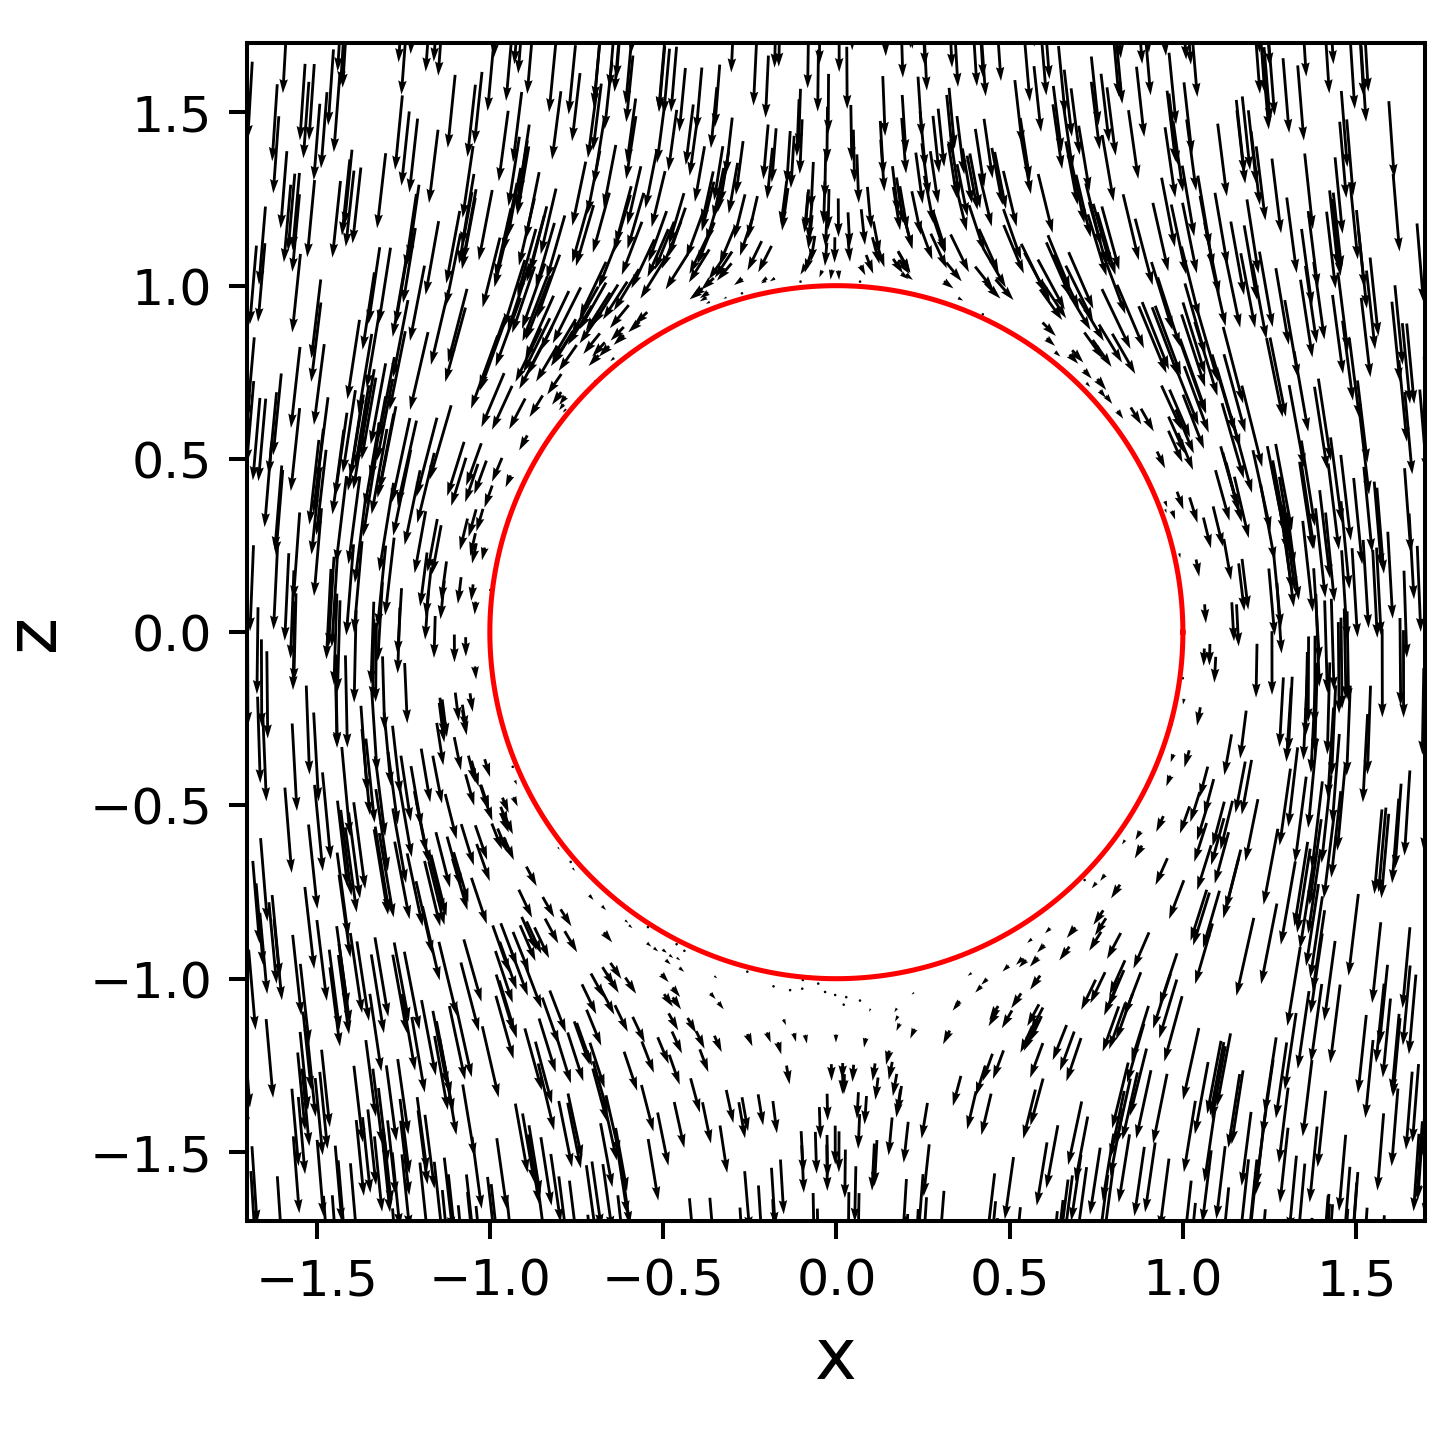

In [19]:
# return velocity vector of wind, in units of v_a = sqrt(GM_a/R_a)
# arguments:
#    rvec position vector, not necessarily on sphere, could be above sphere 
#    tilde_uhw is equal to wind velocity at large radius in units of v_a
#    Re is Reynolds number of flow (about whole planetesimal)
#    omega_vec is spin vector gravitational units
# returns: uvec, velocity vector of wind 
# we assume that wind comes from -z direction, potential flow model 
# BUT with a delta = sqrt(x/Re) Blasius boundary layer giving shear a velocity near surface, no slip
def u_wind_Bl(rvec,tilde_uhw,Re,omega_vec):
    x = rvec[0]; y = rvec[1]; z = rvec[2]
    rmag = np.sqrt(x**2 + y**2 + z**2)
    y_Bl = rmag - 1.0  # distance to surface 
    if (y_Bl <0):
        return 0.0  # cutoff no wind within surface 
    rhat = rvec/rmag
    vrot = v_rotation(rhat,omega_vec)  # rotation velocity of surface 
    fxy = 1.0
    if (Re>0):  # you can run without Boundary layer if you set Re negative or 0
        ctheta = z/rmag  # [-1,1] range
        x_Bl = np.arccos(ctheta)# distance along surface for Bl is always positive , range [0,pi] 
        delta_Bl = np.sqrt((x_Bl + 1e-6)/Re)   # boundary layer thickness, 1e-6 is a trap for x=0 problems
        if (y_Bl < delta_Bl):  # only correct flow within Boundary layer
            fxy = y_Bl/delta_Bl  # this goes from 0 to 1 in boundary layer
     
    # now compute potential flow model
    r3 = rmag**3
    r5 = rmag**5
    r2 = rmag**2
    z2 = z**2
    ux = 1.5*z*x/r5
    uy = 1.5*z*y/r5
    uz = -1 - (0.5/r3)*(1. - 3*z2/r2)
    uvec = np.array([ux,uy,uz])*tilde_uhw  # this is potential flow velocity  
    
    return uvec * fxy  + (1.0 - fxy) * vrot


# make a test routine for u_wind() and a nice figure for it
def test_u_wind_Bl(Re,ofile,omega_vec):
    tilde_uhw = 1.0
    nn = 2000
    uxarr = np.zeros(nn); uyarr = np.zeros(nn); uzarr = np.zeros(nn)
    xarr  = np.zeros(nn); yarr  = np.zeros(nn); zarr  = np.zeros(nn)
    
    for i in range(nn):
        phi = np.random.uniform(low=0,high=2*np.pi)
        rs = np.random.uniform(low=1.0,high=2.4)
        x = rs*np.cos(phi)
        y = 0.0
        z = rs*np.sin(phi)
        xarr[i] = x; yarr[i] = y; zarr[i] = z
        rvec = np.array([x, y, z])
        uvec = u_wind_Bl(rvec,tilde_uhw,Re,omega_vec)
        uxarr[i] = uvec[0]; uyarr[i] = uvec[1]; uzarr[i] = uvec[2]
        
    fig,ax = plt.subplots(1,1,figsize=(4,4),dpi=200,facecolor='white')
    plt.subplots_adjust(left=0.17,right=0.98,top=0.98,bottom=0.15)
    mm = 1.7
    ax.set_xlim([-mm,mm])
    ax.set_ylim([-mm,mm])
    ax.set_aspect(1)
    ax.quiver(xarr,zarr,uxarr,uzarr,scale=15.0)
    ax.set_xlabel('x',fontsize=14)
    ax.set_ylabel('z',fontsize=14)
    
    phi = np.linspace(0,2*np.pi,300)
    xarr = np.cos(phi); yarr = np.sin(phi)
    ax.plot(xarr,yarr,'r-',lw=1)
    if (len(ofile)>3):
        plt.savefig(ofile,dpi=200)
    
Re = 10; ofile = "flow_10.png"  # with nice boundary layer!
omega_vec = np.array([0,0.001,0])
test_u_wind_Bl(Re,ofile,omega_vec)  #looks good! figure without rotation

<IPython.core.display.Javascript object>


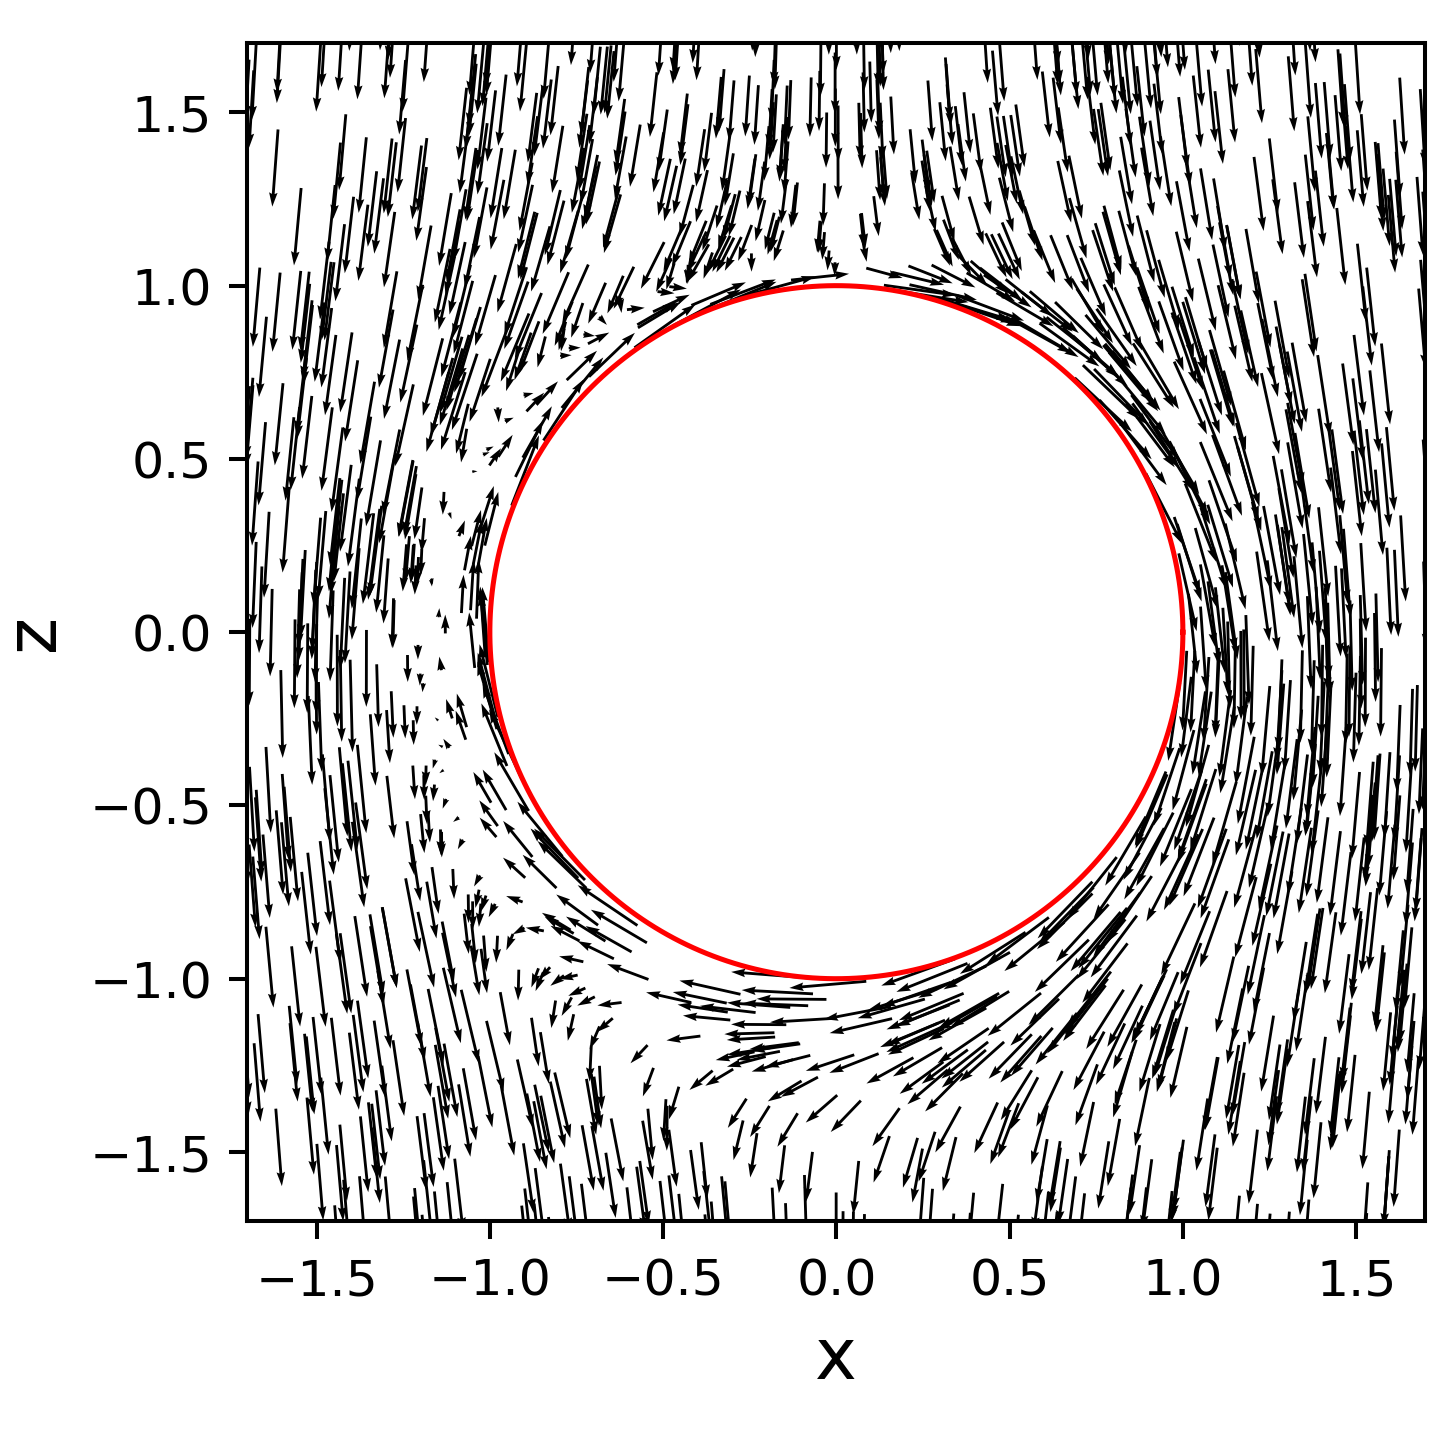

In [20]:
Re = 10; ofile = "flow_10r.png"  # with nice boundary layer with rotation!
omega_vec = np.array([0,1.,0])
test_u_wind_Bl(Re,ofile,omega_vec)  #looks good!, figure with rotation

In [8]:
# some routines for rotating arcs
# arguments:
#    r a position on surface of sphere (units R_a)
#    tilde_Omega_vec  a spin rotation vector  (units Omega_a)
#    Delta_t a  time (units Omega_a^-1)
# returns:
#    new r position after body has rotated 
def rotate_init_position(r,tilde_Omega_a_vec,Delta_t):
    spinval = np.sqrt(np.dot(tilde_Omega_a_vec,tilde_Omega_a_vec))
    spin_axis  = tilde_Omega_a_vec/spinval
    theta = spinval*Delta_t  # how far to rotate 
    rm = rotation_matrix(spin_axis, theta) # create rotation matrix
    new_r = np.dot(rm,r)  # rotate r vector 
    return new_r  # return rotated vector, sign of rotation has been checked 


# create an arc connecting r with points due to rotation for a time Delta t
# returns the arc as a list of points in x,y,z
def rotate_arc(r,tilde_Omega_a_vec,Delta_t):
    spinval = np.sqrt(np.dot(tilde_Omega_a_vec,tilde_Omega_a_vec))
    spin_axis  = tilde_Omega_a_vec/spinval
    npts = 100 
    xarr = np.zeros(npts); yarr = np.zeros(npts); zarr = np.zeros(npts);
    for i in range(npts):
        theta = spinval*Delta_t * float(i)/npts
        rm = rotation_matrix(spin_axis, theta)
        new_r = np.dot(rm,r)
        xarr[i] = new_r[0]
        yarr[i] = new_r[1]
        zarr[i] = new_r[2]
    return xarr,yarr,zarr  


# create an arc along a sphere of radius 1
# between two points assumed on the sphere
# returns an arc as a list of points x,y,z
def create_arc(r1,r2):
    npts = 100
    xarr = np.zeros(npts); yarr = np.zeros(npts); zarr = np.zeros(npts); 
    for i in range(npts):
        mu = float(i)/npts
        r = r1 *(1-mu)  + r2*mu  # vector between r1,r2
        rmag = np.sqrt(np.dot(r,r))
        r /= rmag # normalize 
        xarr[i] = r[0]
        yarr[i] = r[1]
        zarr[i] = r[2]
    return xarr,yarr,zarr
        

In [9]:
# integrated splash particle one timestep of dt 
# arguments:
#  r is position vector (units R_a)
#  v is velocity vector (units v_a)
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  dt step size units t_a 
# returns:
#   rnew, vnew:   new position and velocity after 1 timestep 
def do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    rhalf = r + v*dt/2  #half drift step
    rmag = np.sqrt(np.dot(rhalf,rhalf))
    ac_grav = -rhalf/rmag**3   # acceleration from gravity force in gravity units
    uw = u_wind_Bl(rhalf,tilde_uhw,Re,omega_vec) # compute wind direction 
    ac_drag = (uw - v)/tilde_ts  # force in direction of wind, against motion, looks ok
    vnew = v + (ac_grav + ac_drag)*dt  # kick step
    rnew = rhalf + vnew*dt/2    # half drift step
    return rnew,vnew


#  a class for storing an integration
class integration_data:
    def __init__(self,r_init,v_init,tilde_ts,tilde_uhw,Re,omega_vec,dt):
        self.r_init = r_init  #initial position 
        self.v_init = v_init  # initial velocity 
        self.tilde_ts = tilde_ts  # stopping time in grav units
        self.tilde_uhw = tilde_uhw   # wind speed in grav units
        self.Re = Re  # Reynolds number 
        self.omega_vec = omega_vec  # spin vector grav units 
        self.dt = dt  # timestep
        self.result = -1  # integration result
        self.xarr = []  # arrays for positions of trajectory
        self.yarr = []
        self.zarr = []
        self.tarr = []  # time array
        self.vxarr = []  # arrays for velocities of trajectory
        self.vyarr = []
        self.vzarr = []
        

# integrate splash particle until hits surface or escapes 
# arguments:
#  r_init is initial position vector (units R_a)
#  v_init is initial velocity vector (units v_a)
#  tilde_ts is stop time in gravitational units (units t_a= Omega_a^-1)
#  tilde_uhw is head wind velocity at infinity (units v_a)
#  Re reynolds number of whole flow
#  dt step size units t_a 
# returns: vectors of times, positions and velocities  
#   and a result which tells you what happened to the particle
#   these are returned in a structure 
def do_integration(r_init,v_init,tilde_ts,tilde_uhw,Re,omega_vec,dt):
    xarr = []; yarr = []; zarr = []
    vxarr = [];vyarr = [];vzarr = [];
    tarr = []
    r = r_init; v = v_init 
    x = r[0]; y = r[1]; z = r[2]
    vx = v[0]; vy = v[1]; vz = v[2]
    t = 0.0
    # store initial condition! 
    xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
    vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
    tarr = np.append(tarr,t)
    fine = 1; #keep going until fine==0
    nsteps = 0 # keep track of how many steps we have done

    integration_result = -1 
    # is 0 if impacts surface at end
    # is 1 if particle escapes 
    # is 2 if integration took too long 
    while (fine==1):
        rnew,vnew = do_integration_step_leapfrog(r,v,tilde_ts,tilde_uhw,Re,omega_vec,dt) # take a step
        vmag = np.sqrt(np.dot(vnew,vnew))
        rmag = np.sqrt(np.dot(rnew,rnew))
        nsteps +=1
        if (vmag > 1.1* np.sqrt(2.) and (rmag>1.5)):
            fine=0  # well above escape velocity and away from planestimal so stop integration 
            integration_result = 1  
        if (rmag>2):  # trap for too far away
            fine=0;
            integration_result = 1  # escape
        if (rmag <0.999):
            fine=0  # below surface so stop integration 
            integration_result = 0    # impact 
        if (nsteps > 10000):  # trap for integration going on too long 
            fine=0
            integration_result = 2  
        if (fine>0): # we continue the integration 
            r = rnew
            v = vnew 
            x = r[0]; y = r[1]; z = r[2]
            vx = v[0]; vy = v[1]; vz = v[2]
            # store position and velocity 
            xarr = np.append(xarr,x); yarr = np.append(yarr,y); zarr = np.append(zarr,z)
            vxarr = np.append(vxarr,vx); vyarr = np.append(vyarr,vy); vzarr = np.append(vzarr,vz)
            t += dt
            tarr = np.append(tarr,t)
            
        # put integration output in a structure
        iout = integration_data(r_init,v_init,tilde_ts,tilde_uhw,Re,omega_vec,dt)
        iout.xarr = xarr
        iout.yarr = yarr
        iout.zarr = zarr
        iout.tarr = tarr
        iout.vxarr = vxarr
        iout.vyarr = vyarr
        iout.vzarr = vzarr
        iout.result = integration_result
        
    return iout        
    #return tarr,xarr,yarr,zarr,vxarr,vyarr,vzarr,integration_result
    

# a routine for setting up a nice 3d figure
def set_up_3d(tilde_Omega_a_vec):
    fig = plt.figure(figsize=(3.5,4),facecolor='white',dpi=200)
    ax = fig.add_subplot(projection='3d')
    plt.subplots_adjust(left=0.1,right=0.98,bottom=0.1,top=0.98)
    # Make sphere 
    u = np.linspace(0, 2 * np.pi, 100)
    v = np.linspace(0, np.pi, 100)
    x = 1 * np.outer(np.cos(u), np.sin(v))
    y = 1 * np.outer(np.sin(u), np.sin(v))
    z = 1 * np.outer(np.ones(np.size(u)), np.cos(v))
    # Plot the surface of a sphere
    ax.plot_surface(x, y, z,alpha=0.1)
    
    # plot an arrow showing rotation axis 
    ax.quiver(0, 0, 0, \
          tilde_Omega_a_vec[0], tilde_Omega_a_vec[1], tilde_Omega_a_vec[2], length=1, normalize=True)
    
    ax.set_aspect('equal') # Set an equal aspect ratio
    ax.set_xlabel('X',labelpad=1)
    ax.set_ylabel('Y',labelpad=1)
    ax.set_zlabel('Z',labelpad=2)
    
    # Customize the view angle 
    ax.view_init(elev=20., azim=35, roll=0)
    ax.tick_params(axis='x', pad=0)
    ax.tick_params(axis='y', pad=0)
    return fig,ax


# plot 3D trajectory in axis ax
# arguments:
#   ax is the figure axis for display
#   iout: a structure with some information in it
#   tilde_Omega_a_vec, spin vector 
#   rotbool: plot the point on the surface where it rotated to, if it was not ejected
#   lcolor: what color to plot the trajectory
#   lstyle: what style to plot the trajectory
#   lwi: a line width used in plotting trajectory 
#   lllabel: a text label, perhaps not used 
def plt_result_3d(ax,iout,tilde_Omega_a_vec,rotbool,lstyle,lcolor,lwi,llabel):
    ax.set_aspect('equal') # Set an equal aspect ratio
    tmax = iout.tarr[-1]

    ax.plot(iout.xarr,iout.yarr,iout.zarr,lstyle,lw=lwi,color=lcolor,label=llabel) # plot trajectory
    
    r_init = iout.r_init  # np.array([xarr[0],yarr[0],zarr[0]])  # initial position of trajectory
    r_final = np.array([iout.xarr[-1],iout.yarr[-1],iout.zarr[-1]])  # final position in trajectory
    r_rot = rotate_init_position(r_init,tilde_Omega_a_vec,tmax)  
    # where the impact point on the surface rotated to if it stayed on the surface 
    if (iout.result == 0):
        ax.plot(r_final[0],r_final[1],r_final[2],'o',lw=2,ms=3,color=lcolor)  # what is lcolor?
    ax.plot(r_init[0],r_init[1],r_init[2],'rP',lw=2,ms=6,alpha=0.5)  # initial position shown in red 
    if (rotbool==1):
        ax.plot(r_rot[0],r_rot[1],r_rot[2],'ko',lw=2,ms=3)
    
    # plot rotation arc
    if (iout.result ==0) or (iout.result==1):
        xa,ya,za = rotate_arc(r_init,tilde_Omega_a_vec,tmax)
        if (rotbool==1):
            ax.plot(xa,ya,za,'-',color=lcolor,lw=lwi*0.7)

    return fig,ax
    


elevation 51.3 deg
theta, phi = 89.7 28.5 deg


<IPython.core.display.Javascript object>


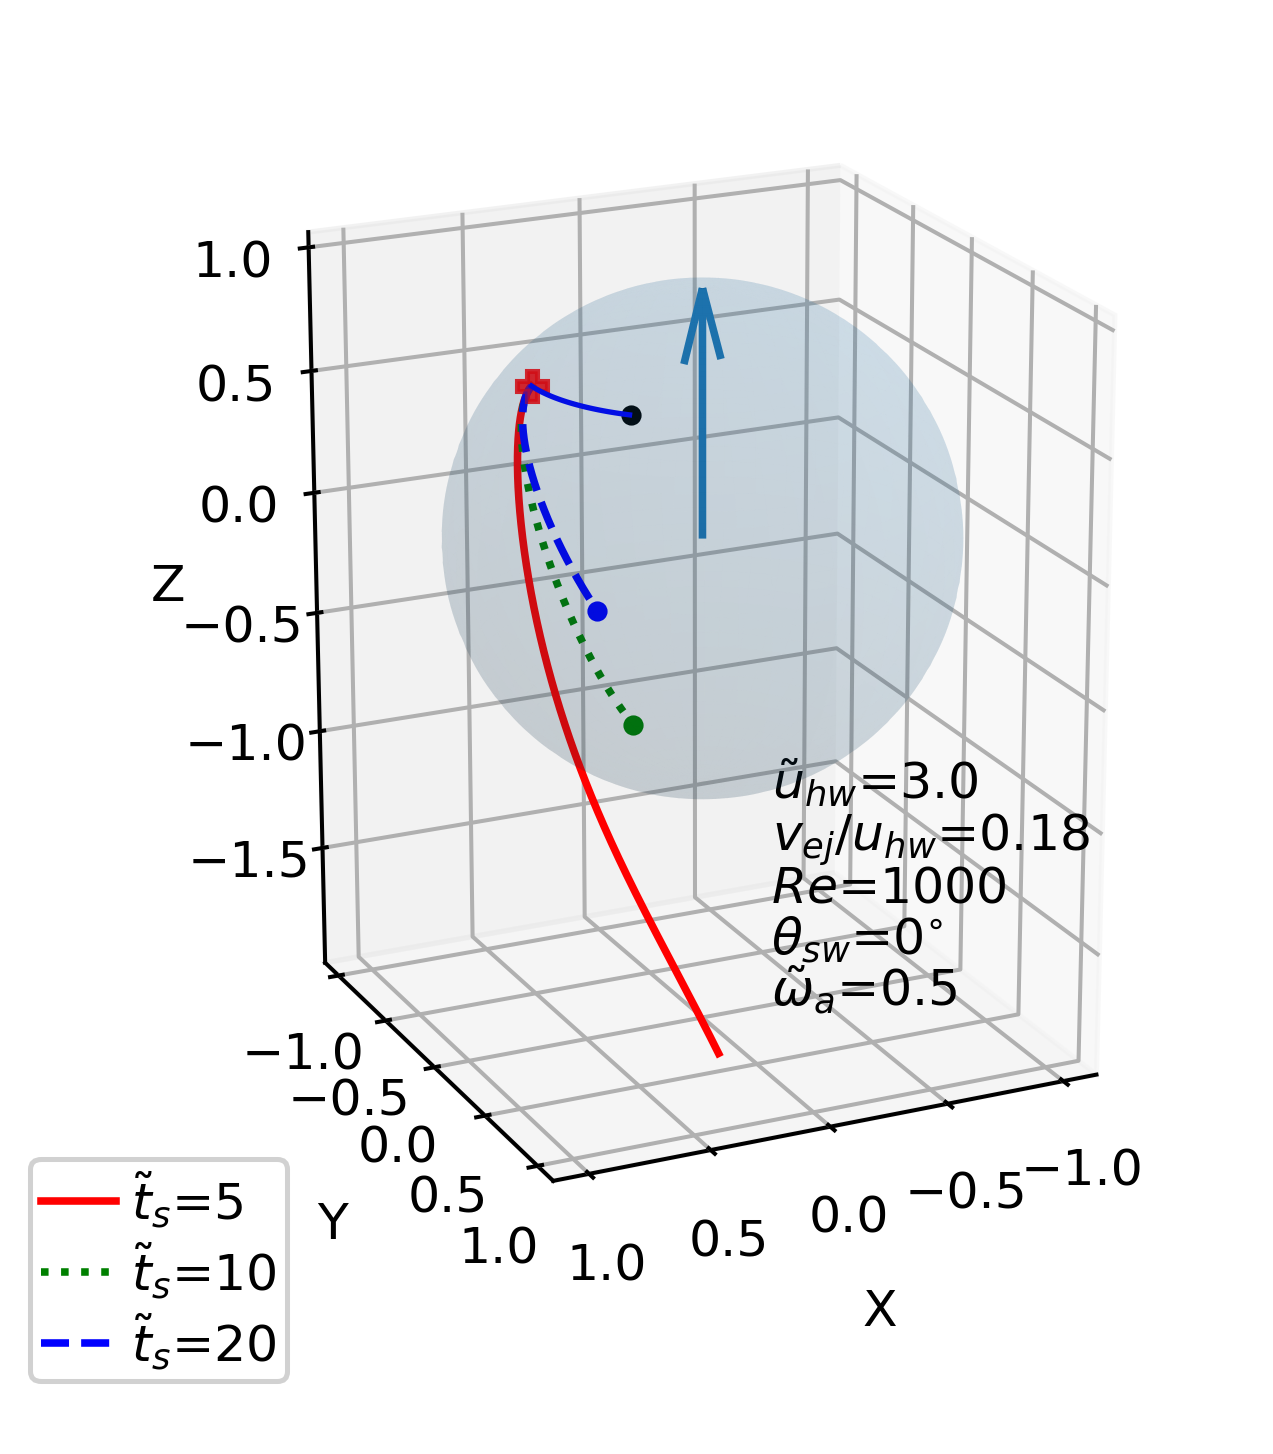

In [27]:
# make the trajs.png figure 
ang = 45.*np.pi/180.  # choose initial particle position 
r_init = np.array([np.sin(ang),0,np.cos(ang)])
v_init_mag = 0.54 # choose vej magnitude  grav units 
tilde_uhw=3.  # choose wind velocity 
Re = 1000. # Choose Reynolds #
# choose spin 
theta_s_deg = 0.  # in degrees   choose angle of spin axis 
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.5  # choose spin rate grav units 
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
v_rot = v_rotation(r_init,tilde_Omega_a_vec) # compute rotation velocity  on surface 
zhat = np.array([0,0,1])
v_impact = -1*tilde_uhw*zhat  # impact velocity in inertial frame 
v_impact_rf = v_impact - v_rot #impact velocity vector in rotating frame

vhat = create_splash_dir(r_init,v_impact_rf) # get direction for splash particle in rotating frame 
vej_rf = v_init_mag*vhat # ejecta velocity vector in rotating frame  
vej_rf += v_rot  # ejecta velocity vector in inertial frame
vej_rf_mag = np.sqrt(np.dot(vej_rf,vej_rf))
vej_hat = vej_rf/vej_rf_mag
v_init = v_init_mag*vej_hat  # changing velocity to be of length v_init_mag

elevation = np.arccos(np.dot(vej_hat,r_init))
print('elevation {:.1f} deg'.format(elevation*180/np.pi))
ztheta = np.arccos(np.dot(vej_hat,zhat))
zphi = np.arctan2(vej_hat[1],vej_hat[0])
print('theta, phi = {:.1f} {:.1f} deg'.format(ztheta*180/np.pi,zphi*180/np.pi) )

#print('tom',tilde_Omega_a_vec)

v_init += v_rot # add rotation to initial velocity vector 
#print(v_rot,v_init)
dt = 0.001  #choose timestep
# do integrations 
tilde_ts1 = 5.0;
iout1 = do_integration(r_init,v_init,tilde_ts1,tilde_uhw,Re,tilde_Omega_a_vec,dt)
tilde_ts2 = 10.0; 
iout2 = do_integration(r_init,v_init,tilde_ts2,tilde_uhw,Re,tilde_Omega_a_vec,dt)
tilde_ts3 = 20.0; 
iout3 = do_integration(r_init,v_init,tilde_ts3,tilde_uhw,Re,tilde_Omega_a_vec,dt)


fig,ax = set_up_3d(tilde_Omega_a_vec) 
plt_result_3d(ax,iout1,tilde_Omega_a_vec,0,'-','red'  ,1.5,r'$\tilde t_s$=5') 
plt_result_3d(ax,iout2,tilde_Omega_a_vec,0,':','green',1.5,r'$\tilde t_s$=10')
plt_result_3d(ax,iout3,tilde_Omega_a_vec,1,'--','blue',1.5,r'$\tilde t_s$=20')

# customize viewing angle!
ax.view_init(elev=20., azim=65, roll=0)

# print parameters!
#print('tilde omega_a {:.1f}'.format(tilde_Omega_a))
#print('theta_s {:.0f}'.format(theta_s_deg))
#print('Re {:.0f}'.format(Re))
#print('v_ej/u_hw {:.1f}'.format(v_init_mag))
#print('tilde uhw {:.1f}'.format(tilde_uhw))
#print('tilde ts {:.1f} {:.1f} {:.1f}'.format(tilde_ts1,tilde_ts2,tilde_ts3))
x0 = -0.3; y0=0.0; z0=-2.0; dz=0.22
astr = r'$\tilde \omega_a$=' + '{:.1f}'.format(tilde_Omega_a) 
bstr = r'$\theta_{sw}$=' + '{:.0f}'.format(theta_s_deg)  + r'$\!^\circ$'
cstr = r'$Re$=' + '{:.0f}'.format(Re)
dstr = r'$v_{ej}/u_{hw}$=' + '{:.2f}'.format(v_init_mag/tilde_uhw)  
estr = r'$\tilde u_{hw}$=' + '{:.1f}'.format(tilde_uhw)  
#fstr = r'$\tilde t_s$=' + '{:.0f},{:.0f},{:.0f}'.format(tilde_ts1,tilde_ts2,tilde_ts3)  
ax.text(x0,y0,z0     ,astr)
ax.text(x0,y0,z0+1*dz,bstr)
ax.text(x0,y0,z0+2*dz,cstr)
ax.text(x0,y0,z0+3*dz,dstr)
ax.text(x0,y0,z0+4*dz,estr)
#ax.text(x0,y0,z0+5*dz,fstr)

ax.legend(loc='lower left',fontsize=10,borderpad=0.2,borderaxespad=0.3,handletextpad=0.3,labelspacing=0.2,\
         handlelength=1.5,framealpha=0.9,ncol=1,columnspacing=1,frameon=True,\
          bbox_to_anchor=(-0.1,-0.15))




plt.savefig('trajs.png',dpi=300)

In [ ]:
# obsolete below

<IPython.core.display.Javascript object>


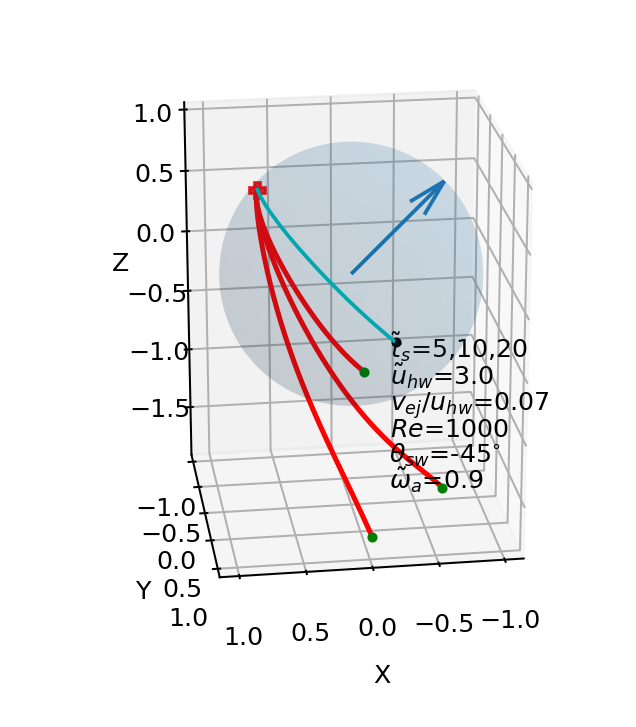

In [87]:
ang = 45.*np.pi/180  # initial particle position 
v_init_mag = 0.2 # choose vej magnitude 
# choose stopping time and wind velocity parms

r_init = np.array([np.sin(ang),0,np.cos(ang)])
vhat = create_splash_dir(r_init) # get direction for splash particle
v_init = v_init_mag*vhat # choose initial velocity vector no spin yet!
Re = 1000. # Reynolds #
#print(v_init)

# choose spin 
theta_s_deg = -45.  # in degrees   # negative only flips x value of spin vec
theta_s = theta_s_deg*np.pi/180.0   # in radians 
tilde_Omega_a = 0.9
tilde_Omega_a_vec = np.array([np.sin(theta_s), 0.0, np.cos(theta_s)]) *tilde_Omega_a
#print('tom',tilde_Omega_a_vec)
v_rot = v_rotation(r_init,tilde_Omega_a_vec) # compute rotation velocity 
v_init += v_rot # add rotation to initial velocity vector 
#print(v_rot,v_init)
dt = 0.001  #choose timestep
# do integrations 
tilde_ts1 = 5.0; tilde_uhw=3.
iout1 = do_integration(r_init,v_init,tilde_ts1,tilde_uhw,Re,tilde_Omega_a_vec,dt)
tilde_ts2 = 10.0; 
iout2 = do_integration(r_init,v_init,tilde_ts2,tilde_uhw,Re,tilde_Omega_a_vec,dt)
tilde_ts3 = 20.0; 
iout3 = do_integration(r_init,v_init,tilde_ts3,tilde_uhw,Re,tilde_Omega_a_vec,dt)

fig,ax = set_up_3d(tilde_Omega_a_vec) 
plt_result_3d(ax,iout1,tilde_Omega_a_vec,0)
plt_result_3d(ax,iout2,tilde_Omega_a_vec,0)
plt_result_3d(ax,iout3,tilde_Omega_a_vec,1)

# customize viewing angle!
ax.view_init(elev=20., azim=65, roll=0)

# print parameters!
#print('tilde omega_a {:.1f}'.format(tilde_Omega_a))
#print('theta_s {:.0f}'.format(theta_s_deg))
#print('Re {:.0f}'.format(Re))
#print('v_ej/u_hw {:.1f}'.format(v_init_mag))
#print('tilde uhw {:.1f}'.format(tilde_uhw))
#print('tilde ts {:.1f} {:.1f} {:.1f}'.format(tilde_ts1,tilde_ts2,tilde_ts3))
x0 = -0.3; y0=0.0; z0=-1.8; dz=0.22
astr = r'$\tilde \omega_a$=' + '{:.1f}'.format(tilde_Omega_a) 
bstr = r'$\theta_{sw}$=' + '{:.0f}'.format(theta_s_deg)  + r'$\!^\circ$'
cstr = r'$Re$=' + '{:.0f}'.format(Re)
dstr = r'$v_{ej}/u_{hw}$=' + '{:.2f}'.format(v_init_mag/tilde_uhw)  
estr = r'$\tilde u_{hw}$=' + '{:.1f}'.format(tilde_uhw)  
fstr = r'$\tilde t_s$=' + '{:.0f},{:.0f},{:.0f}'.format(tilde_ts1,tilde_ts2,tilde_ts3)  
ax.text(x0,y0,z0     ,astr)
ax.text(x0,y0,z0+1*dz,bstr)
ax.text(x0,y0,z0+2*dz,cstr)
ax.text(x0,y0,z0+3*dz,dstr)
ax.text(x0,y0,z0+4*dz,estr)
ax.text(x0,y0,z0+5*dz,fstr)

plt.savefig('trajs_b.png',dpi=300)